## MVP
My goal is to predict one of 3 potential outcomes for the Austin Animal Center's animal intake. Because this is a multi class prediction, my base model is a random forest using the initial 12 features and adding another 12 I engineered from the incoming data set. I then tuned on the hyper parameters of n_estimators and num_features. I landed on 150 n_estimators and 9 num_features using 5-fold cross validation. This is an imbalanced data set as Euthanasia makes up 4% of the total records (seen below)

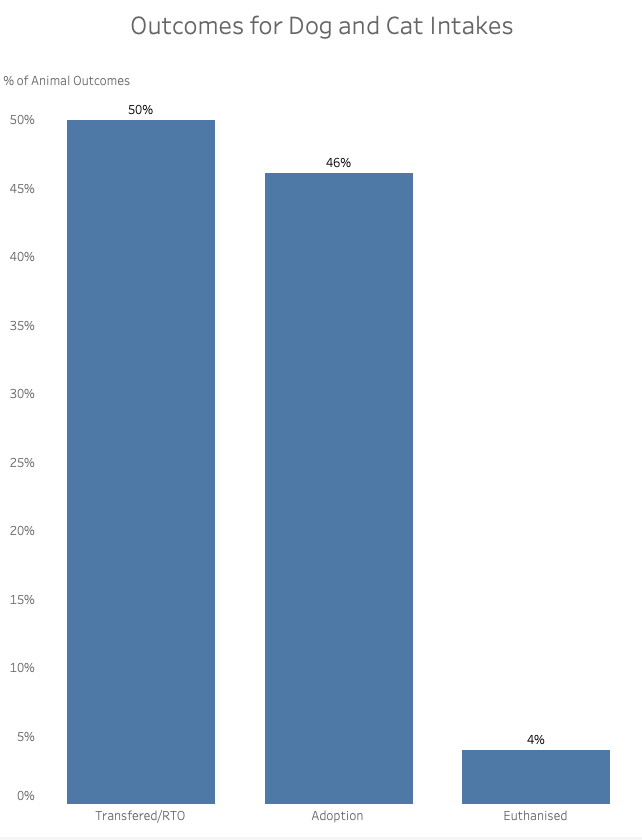

I am mainly focused on recall, as the animal center has an agreement to maintain a rate of 10% or less for euthanasia, so finding all potential euthanasia outcomes is important as a way to triage and meet the 10% SLA.

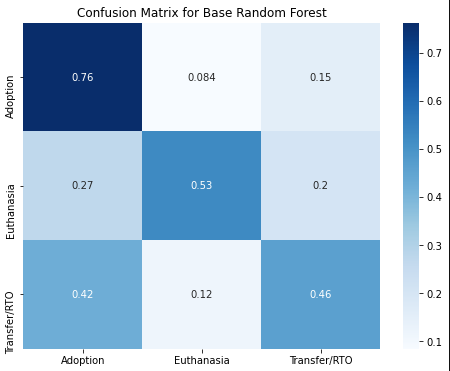

As seen in the confusion matrix above, which is normalized to represent recall, the recall for adoption is high at 76%. Euthanasia is lower at 53%, and Transfer/RTO is lowest at 46%. The overall weighted recall for the model is 60%.

I plan on tuning the hyper parameters, as well as creating an XGBoost model to improve recall.

In terms of importance, the top 10 features by importance can be seen below:

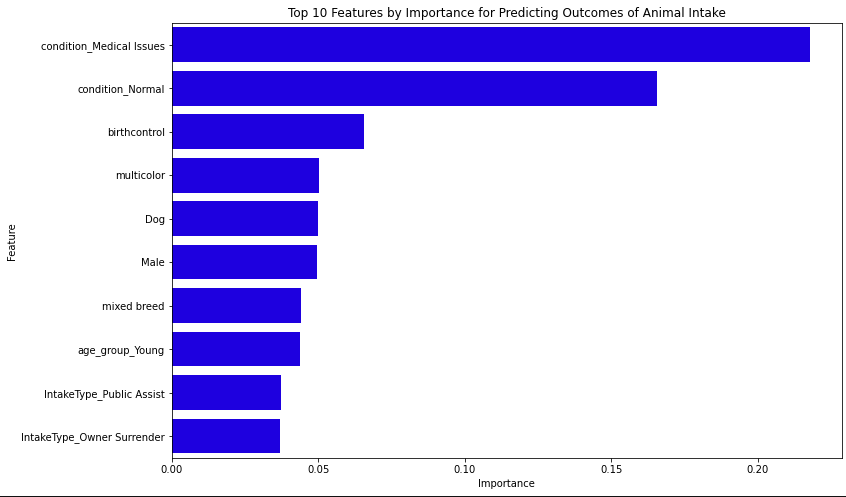

This makes sense as the first 2 features represent the condition of the animal on intake, so if an animal is injured or in normal condition it has a large impact on the prediction of an outcome.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, make_scorer, recall_score
from sklearn.linear_model import LogisticRegression

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
feats_dummy = pd.read_pickle(r'/Users/philliprichardson/Metis/Module 4/feats.pkl')
outcome = pd.read_pickle(r'/Users/philliprichardson/Metis/Module 4/outcome.pkl')

In [23]:
kf = StratifiedKFold(n_splits = 5, random_state = 13, shuffle = True)


def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, stratify = y, random_state = 13)
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    score = np.mean(cross_val_score(model, X, y, cv=kf, scoring = make_scorer(recall_score, average = 'weighted')))
    fitting = np.std(cross_val_score(model, X, y, cv=kf, scoring = make_scorer(recall_score, average = 'weighted')))
    return score, fitting


In [19]:
randomforest_bal = RandomForestClassifier(n_estimators=150, max_features = 9, class_weight = 'balanced')


In [24]:
lst = [randomforest_bal]

for i in lst:
    print(quick_test(i, feats_dummy, outcome))
    

(0.6006744876533876, 0.0021264471758407136)


In [7]:
feature_importance = pd.DataFrame(feats_dummy.columns).merge(pd.DataFrame(randomforest_bal.feature_importances_), left_index = True, right_index = True)

feature_importance.columns = ['Feature', 'Importance']

feature_importance.sort_values(by = 'Importance', inplace = True, ignore_index = True, ascending = False)

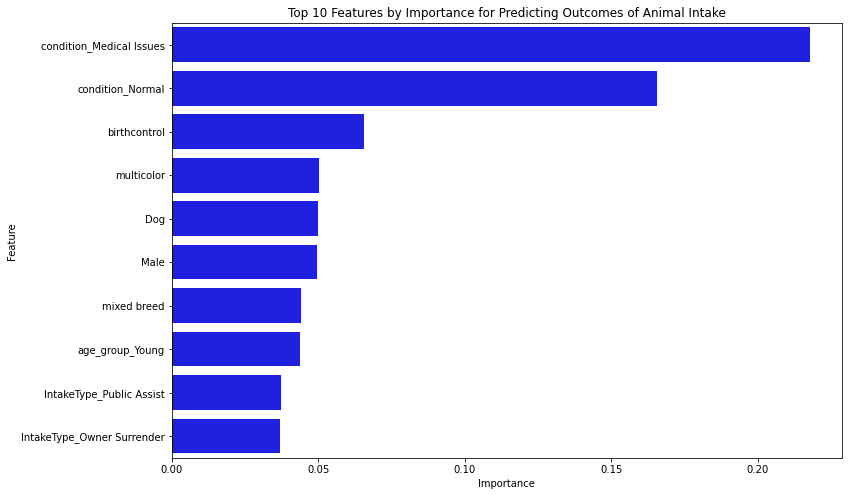

In [17]:
plt.figure(figsize=(12,8))
plt.title("Top 10 Features by Importance for Predicting Outcomes of Animal Intake")
sns.barplot(y = 'Feature', x = 'Importance', data=feature_importance.iloc[:10], color = 'blue');
plt.savefig(r'/Users/philliprichardson/Metis/Module 4/mvp Importance.png')

In [10]:
xtrain, xtest, ytrain, ytest = train_test_split(feats_dummy, outcome, test_size=0.2, stratify = outcome, random_state = 13)
arr = confusion_matrix(ytest, randomforest_bal.predict(xtest), normalize = 'true')
print(classification_report(ytest, randomforest_bal.predict(xtest)))
arr
conf_mat = pd.DataFrame(arr, columns = ['Adoption', 'Euthanasia', 'Transfer/RTO'], index = ['Adoption', 'Euthanasia', 'Transfer/RTO'])

                precision    recall  f1-score   support

      Adoption       0.61      0.76      0.68      9354
    Euthanised       0.18      0.53      0.26       798
Transfered/RTO       0.75      0.46      0.57     10131

      accuracy                           0.60     20283
     macro avg       0.51      0.58      0.50     20283
  weighted avg       0.66      0.60      0.61     20283



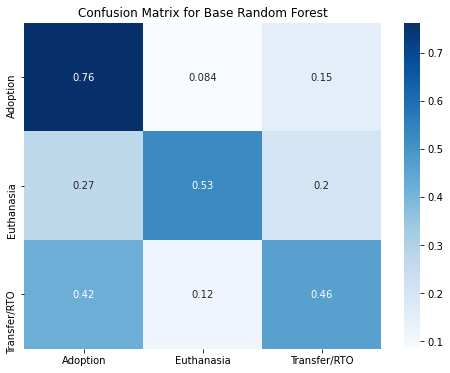

In [13]:
plt.figure(figsize=(8,6))
plt.title('Confusion Matrix for Base Random Forest')
sns.heatmap(conf_mat, cmap="Blues", annot = True);
plt.savefig(r'/Users/philliprichardson/Metis/Module 4/mvp confusion.png')